<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/capfloor_valuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caps and floors

In [1]:
!pip install QuantLib-Python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 33.7 MB/s eta 0:00:00


In this post, I will walk you through a simple example of valuing caps. I want to talk about two specific cases:

1. Value caps given a constant volatility
2. Value caps given a cap volatility surface

Caps, as you might know, can be valued as a sum of caplets. The value of each caplet is determined by the Black formula. In practice, each caplet would have a different volatility. Meaning, a caplet that is in the near term can have a different volatility profile compared to the caplet that is far away in tenor. Similarly caplet volatilities differ with the strike as well.

In [2]:
import QuantLib as ql

In [13]:
import urllib.request
import importlib.util
import sys

# URL of the Python file
url = 'https://raw.githubusercontent.com/aderdouri/ql_web_app/master/ql_notebooks/utils.py'

# Download the file
urllib.request.urlretrieve(url, 'utils.py')

# Import the module
spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["utils"] = utils
spec.loader.exec_module(utils)

In [14]:
calc_date = ql.Date(14, 6, 2016)
ql.Settings.instance().evaluationDate = calc_date

#### Constant Volatility

Let us start by constructing different components required in valuing the caps. The components that we would need are:

1. interest rate term structure for discounting
2. interest rate term structure for the floating leg
3. construction of the cap
4. the pricing engine to value caps using the Black formula

For simplicity, we will construct only one interest rate term structure here, and assume that the discounting and the floating leg is referenced by the same. Below the term structure of interest rates is constructed from a set of zero rates.

In [15]:
dates = [ql.Date(14,6,2016),  ql.Date(14,9,2016),
         ql.Date(14,12,2016), ql.Date(14,6,2017),
         ql.Date(14,6,2019),  ql.Date(14,6,2021),
         ql.Date(15,6,2026),  ql.Date(16,6,2031),
         ql.Date(16,6,2036),  ql.Date(14,6,2046)
         ]
yields = [0.000000, 0.006616, 0.007049, 0.007795,
          0.009599, 0.011203, 0.015068, 0.017583,
          0.018998, 0.020080]

day_count = ql.ActualActual(ql.ActualActual.ISDA)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
interpolation = ql.Linear()
compounding = ql.Compounded
compounding_frequency = ql.Annual

term_structure = ql.ZeroCurve(dates, yields, day_count,
                              calendar, interpolation,
                              compounding, compounding_frequency)
ts_handle = ql.YieldTermStructureHandle(term_structure)

As a next step, lets construct the cap itself. In order to do that, we start by constructing the `Schedule` object to project the cash-flow dates.

In [16]:
start_date = ql.Date(14, 6, 2016)
end_date = ql.Date(14, 6 , 2026)
period = ql.Period(3, ql.Months)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
bus_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False

schedule = ql.Schedule(start_date, end_date, period,
                       calendar, bus_convention,
                       bus_convention, rule, end_of_month)

Now that we have the schedule, we construct the `USDLibor` index. Below, you can see that I use `addFixing` method to provide a fixing date for June 10, 2016. According the schedule constructed, the start date of the cap is June 14, 2016, and there is a 2 business day settlement lag (meaning June 10 reference date) embedded in the `USDLibor` definition. So in order to set the rate for the accrual period, the rate is obtained from the fixing data provided. For all future dates, the libor rates are automatically inferred using the forward rates provided by the given interest rate term structure.

In [17]:
ibor_index = ql.USDLibor(ql.Period(3, ql.Months), ts_handle)
ibor_index.addFixing(ql.Date(10,6,2016), 0.0065560)

ibor_leg = ql.IborLeg([1000000], schedule, ibor_index)

Now that we have all the required pieces, the `Cap` can be constructed by passing the `ibor_leg` and the `strike` information. Constructing a floor is done through the `Floor` class. The `BlackCapFloorEngine` can be used to price the cap with constant volatility as shown below.

In [18]:
strike = 0.02
cap = ql.Cap(ibor_leg, [strike])

vols = ql.QuoteHandle(ql.SimpleQuote(0.547295))
engine = ql.BlackCapFloorEngine(ts_handle, vols)

cap.setPricingEngine(engine)
print(cap.NPV())

54369.85806286924


#### Using Volatility Surfaces

In the above exercise, we used a constant volatility value. In practice, one needs to strip the market quoted cap/floor volatilities to infer the volatility of each caplet. QuantLib provides excellent tools in order to do that. Let us assume the following dummy data represents the volatility surface quoted by the market. I have the various `strikes`, `expiries`, and the volatility quotes in percentage format. I take the raw data and create a `Matrix` in order to construct the volatility surface.

In [19]:
strikes = [0.01,0.015, 0.02]
temp = list(range(1, 11)) + [12]
expiries = [ql.Period(i, ql.Years) for i in temp]
vols = ql.Matrix(len(expiries), len(strikes))
data = [
    [47.27, 55.47, 64.07, 70.14, 72.13, 69.41,
     72.15, 67.28, 66.08, 68.64, 65.83],
    [46.65, 54.15, 61.47, 65.53, 66.28, 62.83,
     64.42, 60.05, 58.71, 60.35, 55.91],
    [46.60, 52.65, 59.32, 62.05, 62.00, 58.09,
     59.03, 55.00, 53.59, 54.74, 49.54]
]

for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i]/100.0

The `CapFloorTermVolSurface` offers a way to store the cap/floor volatilities. These are however `CapFloor` volatilities, and not the volatilities of the individual options.

In [20]:
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(
    settlement_days, calendar, bdc,
    expiries, strikes, vols, daycount
)

The `OptionletStripper1` class lets you to strip the individual caplet/floorlet volatilities from the cap/floor volatilities. We have to 'jump' some hoops here to make it useful for pricing. The `OptionletStripper1` class cannot be consumed directly by a pricing engine. The `StrippedOptionletAdapter` takes the stripped optionlet volatilities, and creates a term structure of optionlet volatilities. We then wrap that into a handle using `OptionletVolatilityStructureHandle`.

In [21]:
optionlet_surf = ql.OptionletStripper1(
    capfloor_vol, ibor_index, ql.nullDouble(),
    1e-6, 100, ts_handle
)
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)

Below, we visualize the cap/floor volatility surface, and the optionlet volatility surface for a fixed strike.

In [22]:
import utils
import numpy as np
%matplotlib inline

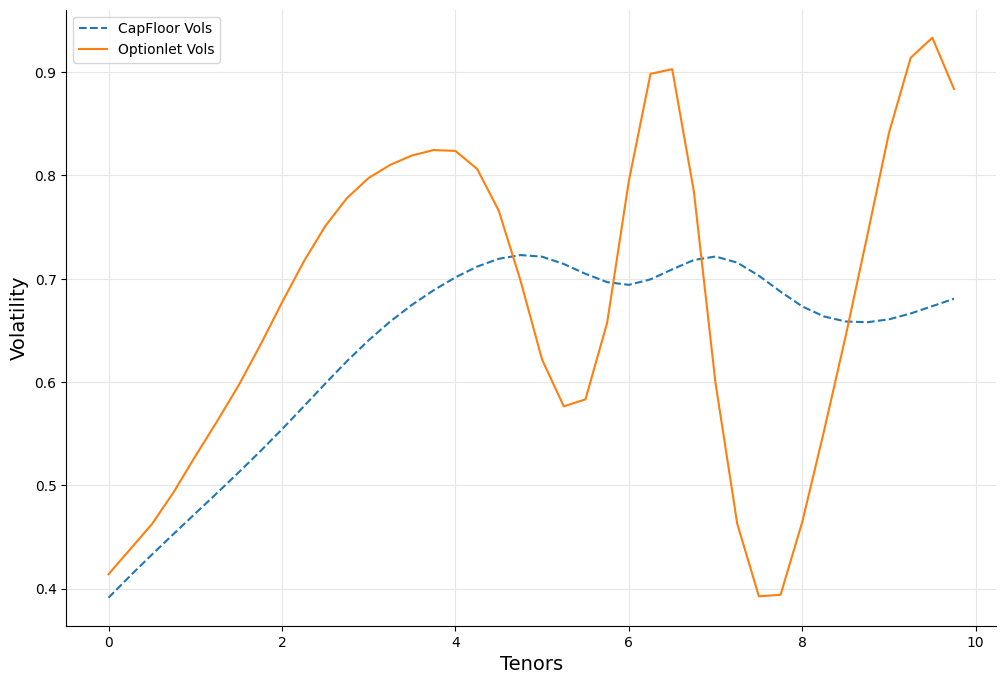

In [23]:
tenors = np.arange(0,10,0.25)
strike = 0.01
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
opionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

fig, ax = utils.plot()
ax.plot(tenors, capfloor_vols, "--", label="CapFloor Vols")
ax.plot(tenors, opionlet_vols,"-", label="Optionlet Vols")
ax.legend(loc='best')
ax.set_xlabel("Tenors", size=14)
ax.set_ylabel("Volatility", size=14);

The `BlackCapFloorEngine` can accept the optionlet volatility surface in order to price the caps or floors.

In [24]:
engine2 = ql.BlackCapFloorEngine(ts_handle, ovs_handle)
cap.setPricingEngine(engine2)
print(cap.NPV())

54384.928314950135


One can infer the implied volatility for the cap at its NPV, and it should be in agreement with what is quote by the surface.

In [25]:
cap.impliedVolatility(cap.NPV(), ts_handle, 0.4)

0.547443893092885

The QuantLib C++ class allow for one to view the projected cash flows in terms of individual caplets.